In [1]:
import zipfile
import pandas as pd
from pandas_profiling import ProfileReport
import random

#zf = zipfile.ZipFile("https://github.com/alexmjn/Predicting-Arrests/blob/master/offenses-standardized.csv.zip")
#crime = pd.read_csv(zf.open("offenses.standardized.csv"))

import category_encoders as ce
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from pandas_profiling import ProfileReport
from scipy.stats import uniform, randint

from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import SimpleImputer
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score, RandomizedSearchCV
from sklearn.pipeline import make_pipeline

from IPython.display import display

In [2]:
 #crime = pd.read_csv("C:/Users/ajenk/GitHub/Crime_Data/offenses-standardized.csv")

In [3]:
# might want to explicitly set dtypes

In [4]:
#crime.dtypes

In [14]:
#crime.shape

(747658, 31)

In [15]:
#profile = ProfileReport(crime, minimal=True).to_notebook_iframe()
#profile

In [2]:
filename = "C:/Users/ajenk/GitHub/Crime_Data/offenses-standardized.csv"
random.seed(42)
p = .2
fields = ["row_hash", "agency_name", "occurred_date", 
          "occurred_time", "firearm_ind", "offense_group", "domestic_violence_ind", "victim_age",
          "victim_race", "victim_ethnicity", "victim_race_condensed", "victim_sex",
         "arrest_ind", "clearance_group"]

crime = pd.read_csv(filename, usecols = fields, skiprows = lambda i: i > 0 and random.random() > p)

C:\Users\ajenk\Anaconda3\envs\unit2\lib\site-packages\IPython\core\interactiveshell.py:3051: DtypeWarning: Columns (20) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [3]:
from sklearn.model_selection import train_test_split

In [4]:
train, test = train_test_split(crime, test_size = .2, random_state = 42)

In [14]:
train.describe(include = "all")

,row_hash,agency_name,occurred_date,occurred_time,firearm_ind,offense_group,domestic_violence_ind,victim_age,victim_race,victim_ethnicity,victim_race_condensed,victim_sex,arrest_ind,clearance_group
count,119476,119476,119464,116547,119476,119476,75120,44264,45842,32065,119476,45829,109871,119476
unique,119476,22,8302,1440,6,7,5,198,46,22,3,14,3,5
top,ILCPD0000-A7498BB51A-01-01,CHICAGO-PD,2011-01-01,00:00,N,Agg Assault - Other Weapon,N,21,BLACK,N,OTHER/UNKNOWN,M,N,Open & No Arrest-Unspecified
freq,1,44563,51,3862,69062,67908,59125,1123,13817,8256,76218,20992,72870,71197


In [15]:
profile = ProfileReport(crime, minimal=True).to_notebook_iframe()
profile

In [27]:
train["arrest_ind"].value_counts()

N    69695
Y    24545
Name: arrest_ind, dtype: int64

In [25]:
train["clearance_group"].value_counts()

Open & No Arrest-Unspecified           73154
Cleared-Arrest & Arrest-Unspecified    24595
Cleared/Closed-Unspecified              2245
Cleared-Ex                                 6
Name: clearance_group, dtype: int64

I think "Arrest Made" is going to be the variable of interest here. Less missing data in clearance_group, so I can cast this into a binary: "cleared" or "open & no arrest." I want to learn more about "Cleared/Closed - Unspecified" as well.

In [5]:
# wrangle - function of functions
# comprehensible (call expressive names within wrangle)

def wrangle(df):
    df = df.copy()
    df["occurred_date"] = pd.to_datetime(df["occurred_date"], infer_datetime_format=True)
    df["occurred_time"] = pd.to_datetime(df["occurred_time"], infer_datetime_format=True)
    
    df["hour"] = df["occurred_time"].dt.hour
    df["hour_zero"] = df["occurred_time"] == pd.to_datetime("00:00")
    df["year"] = df["occurred_date"].dt.year
    df["month"] = df["occurred_date"].dt.month
    #could maybe do something with minutes - does time logging matter?
    df["cleared"] = ~(df["clearance_group"] == "Open & No Arrest-Unspecified")
    
    df["victim_age"] = df["victim_age"].replace({"UNDER 18": "17"})
    
    
    df["victim_age"] = df["victim_age"].astype("float")
    
    # todo: check for holidays (individual or otherwise); seasons/seasonal trends; 
    # day of week - import datetime; datetime.datetime().weekday()
    # create categorical variable from age
    
    return df

In [6]:
train = wrangle(train)
train.shape

(119476, 19)

In [7]:
test = wrangle(test)
test.shape

(29870, 19)

In [32]:
train["cleared"].value_counts(normalize = True)

False    0.59591
True     0.40409
Name: cleared, dtype: float64

In [33]:
train.columns

Index(['row_hash', 'agency_name', 'occurred_date', 'occurred_time',
       'firearm_ind', 'offense_group', 'domestic_violence_ind', 'victim_age',
       'victim_race', 'victim_ethnicity', 'victim_race_condensed',
       'victim_sex', 'arrest_ind', 'clearance_group', 'hour', 'hour_zero',
       'year', 'month', 'cleared'],
      dtype='object')

In [13]:
target = "cleared"
features = train.drop([target, "row_hash", "clearance_group", "arrest_ind", "occurred_date", "occurred_time"], axis = 1).columns.to_list()

In [14]:
X_train = train[features]
y_train = train[target]
X_test = test[features]
y_test = test[target]

In [15]:
X_train.dtypes

#looks like 40 depth, 4 samples per leaf, estimators 700-1200, agnostic mean/median.
# try flagging missing data.
# try flagging missing data. get feat importances. check on redundant areas.
# for imputation check what's missing and present per agency.

agency_name               object
firearm_ind               object
offense_group             object
domestic_violence_ind     object
victim_age               float64
victim_race               object
victim_ethnicity          object
victim_race_condensed     object
victim_sex                object
hour                     float64
hour_zero                   bool
year                     float64
month                    float64
dtype: object

In [43]:
def generate_most_common(feature):
    train_plot = train.copy()
    top_obs = train_plot[feature].value_counts()[:8].index
    train_plot.loc[~train_plot[feature].isin(top_obs), feature] = "other"
    
    return train_plot

def graph_feature(feature):
    train_plot = generate_most_common(feature = feature)
    
    fig, ax = plt.subplots(figsize = (25, 10))

    sns.countplot(x = train_plot[feature], hue = train_plot[target])
    ax.tick_params(axis = 'both', labelsize = 16)
    plt.show()

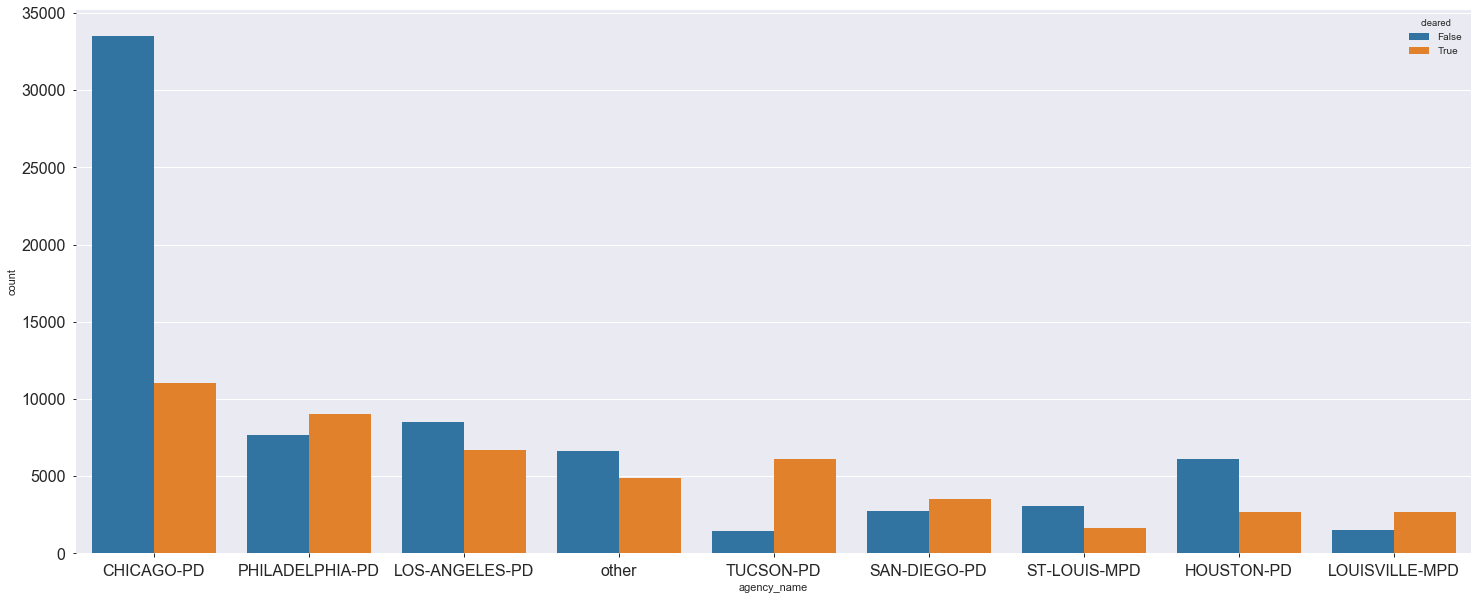

In [44]:
graph_feature("agency_name")

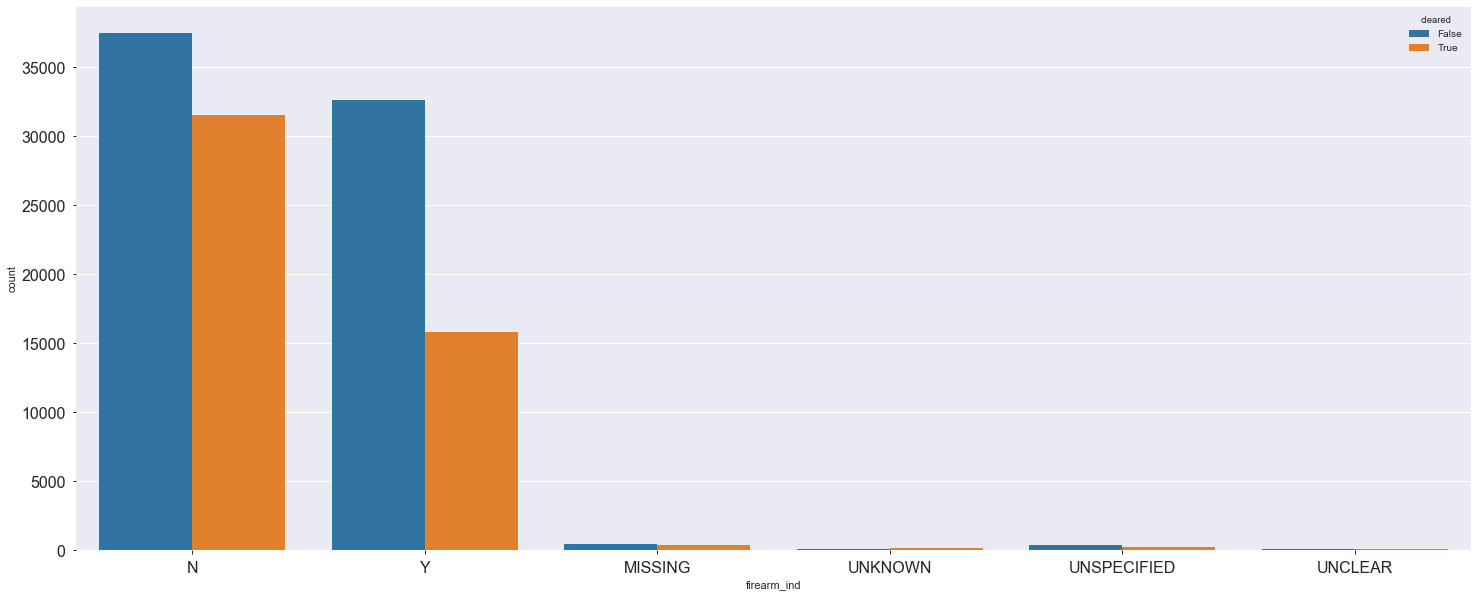

In [33]:
graph_feature("firearm_ind")

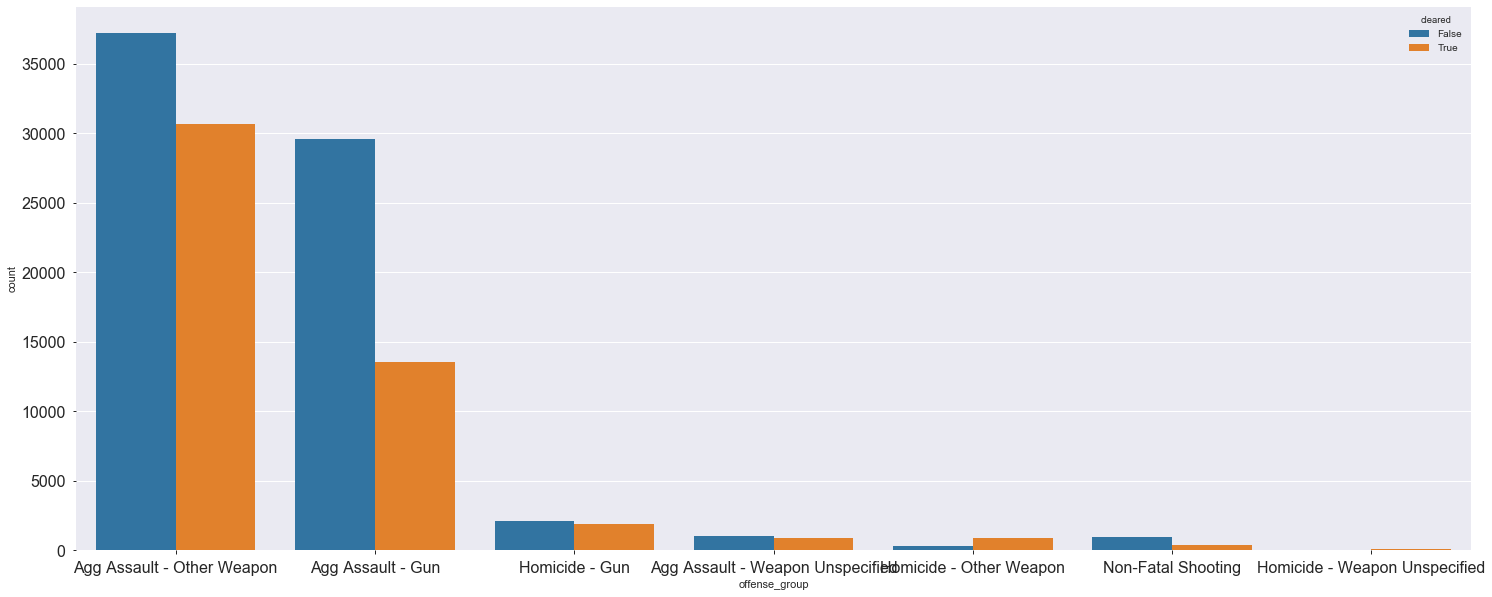

In [34]:
graph_feature("offense_group")

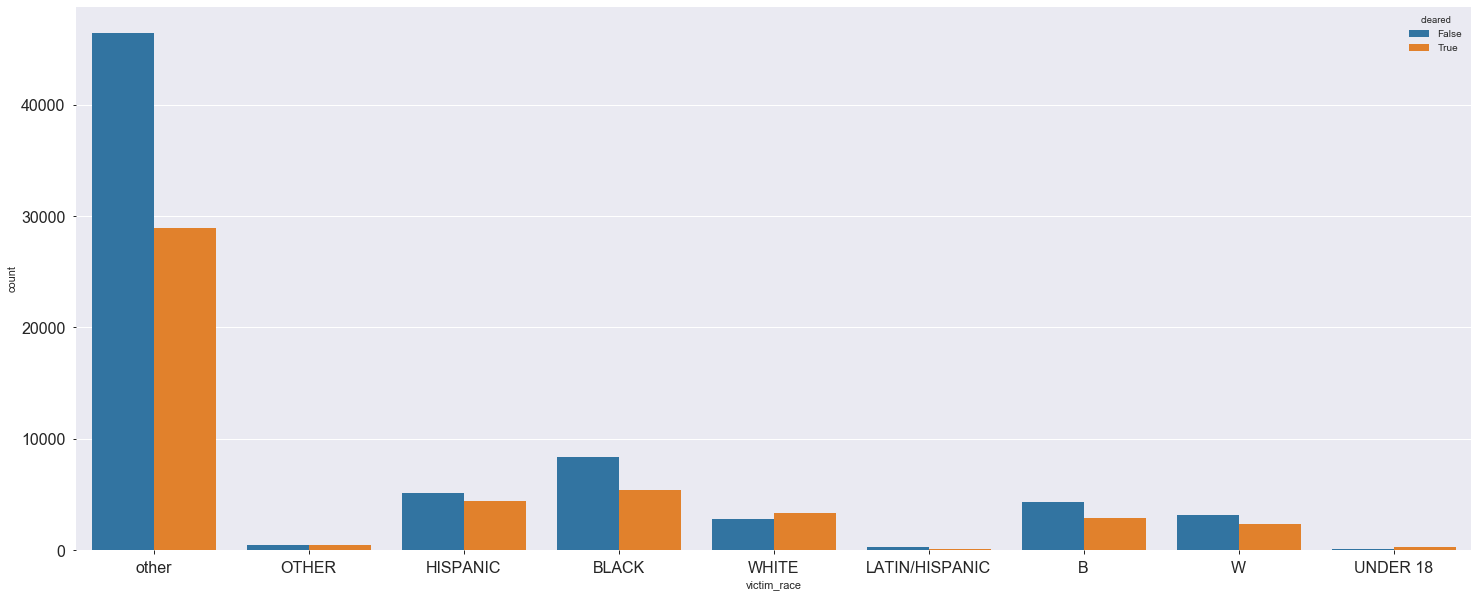

In [36]:
graph_feature("victim_race")

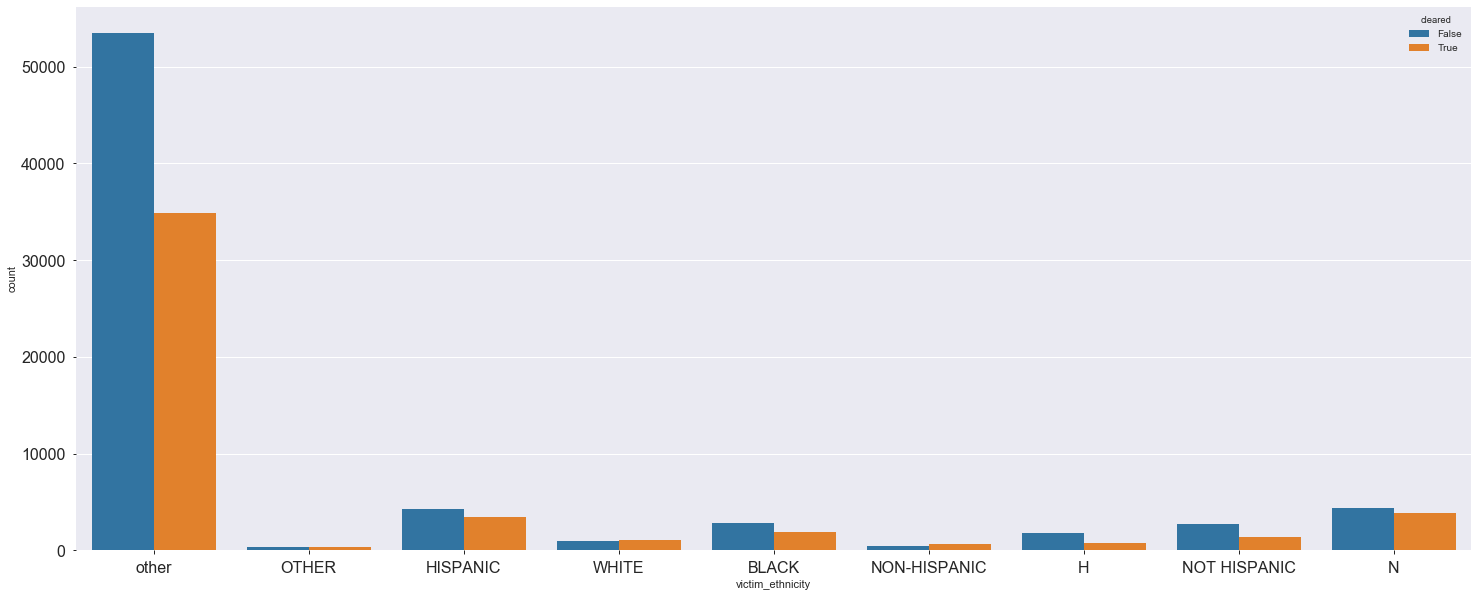

In [38]:
graph_feature("victim_ethnicity")

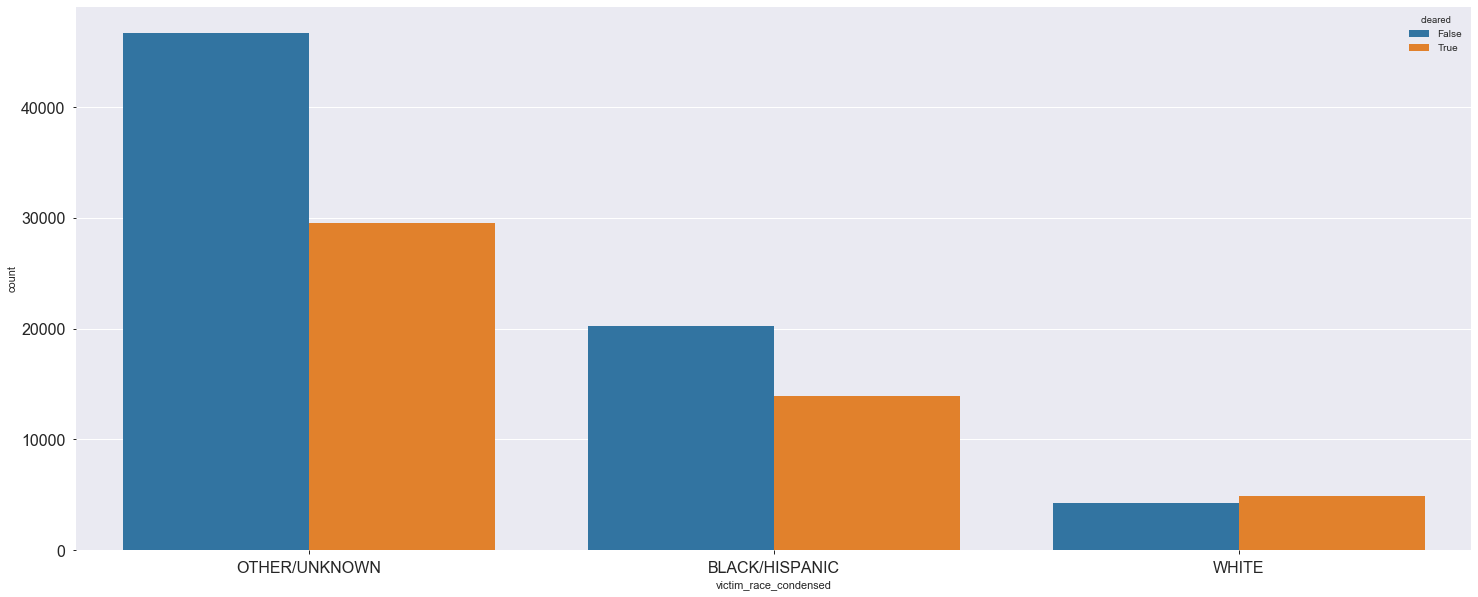

In [39]:
graph_feature("victim_race_condensed")

In [10]:
pipeline = make_pipeline(
    ce.OrdinalEncoder(),
    SimpleImputer(),
    #handle on a feature's null values feature by feature
    RandomForestClassifier(random_state = 42)
)

param_distributions = {
    'simpleimputer__strategy' : ['mean', 'median'],
    'randomforestclassifier__n_estimators': randint(100, 1500),
    'randomforestclassifier__max_depth': [5, 15, 25, 40, 50],
    'randomforestclassifier__min_samples_leaf': randint(1, 5)
}

search = RandomizedSearchCV(
    pipeline,
    param_distributions = param_distributions,
    n_iter = 7,
    cv = 4,
    scoring = 'accuracy',
    verbose = 10,
    return_train_score = True,
    n_jobs = -1
    )

search.fit(X_train, y_train)

Fitting 4 folds for each of 7 candidates, totalling 28 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:  2.4min
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:  5.6min
[Parallel(n_jobs=-1)]: Done  24 out of  28 | elapsed:  8.2min remaining:  1.4min
[Parallel(n_jobs=-1)]: Done  28 out of  28 | elapsed: 11.5min finished


RandomizedSearchCV(cv=4, error_score=nan,
                   estimator=Pipeline(memory=None,
                                      steps=[('ordinalencoder',
                                              OrdinalEncoder(cols=None,
                                                             drop_invariant=False,
                                                             handle_missing='value',
                                                             handle_unknown='value',
                                                             mapping=None,
                                                             return_df=True,
                                                             verbose=0)),
                                             ('simpleimputer',
                                              SimpleImputer(add_indicator=False,
                                                            copy=True,
                                                            fill_value=None,


In [11]:
print(search.best_params_)
print(search.best_score_)
pd.DataFrame(search.cv_results_).sort_values(by='rank_test_score').T

{'randomforestclassifier__max_depth': 25, 'randomforestclassifier__min_samples_leaf': 4, 'randomforestclassifier__n_estimators': 328, 'simpleimputer__strategy': 'median'}
0.6907161270882854


,1,5,3,6,0,2,4
mean_fit_time,58.0671,116.885,111.939,157.536,21.4882,30.9896,40.4576
std_fit_time,0.321876,0.462339,0.275776,0.268648,0.0989057,0.261758,0.304304
mean_score_time,3.33455,6.7856,6.35269,9.86135,1.29876,1.81363,2.38038
std_score_time,0.248278,0.339104,0.476142,0.357639,0.0926907,0.0981014,0.164395
param_randomforestclassifier__max_depth,25,15,25,15,5,40,40
param_randomforestclassifier__min_samples_leaf,4,2,3,1,2,2,1
param_randomforestclassifier__n_estimators,328,759,611,962,271,155,189
param_simpleimputer__strategy,median,median,median,mean,median,median,median
params,"{'randomforestclassifier__max_depth': 25, 'ran...","{'randomforestclassifier__max_depth': 15, 'ran...","{'randomforestclassifier__max_depth': 25, 'ran...","{'randomforestclassifier__max_depth': 15, 'ran...","{'randomforestclassifier__max_depth': 5, 'rand...","{'randomforestclassifier__max_depth': 40, 'ran...","{'randomforestclassifier__max_depth': 40, 'ran..."
split0_test_score,0.673675,0.671398,0.6718,0.668653,0.67642,0.667347,0.664033


My first model - with a max depth of 25, 4 features per leaf, an imputer strategy of "Median" (no flags), and 328 estimators got a score of .690. This comfortably beats the baseline. Because of a prior hyperparam search that stopped early, I know this isn't even the best model -- 40/4/X/1000 got around .698 -- but this is suitable for me to plot feature importances and start to look at feature engineering, further data cleanup, etc.

I fit a pipeline with the parameters found through param search then plot feature importances.

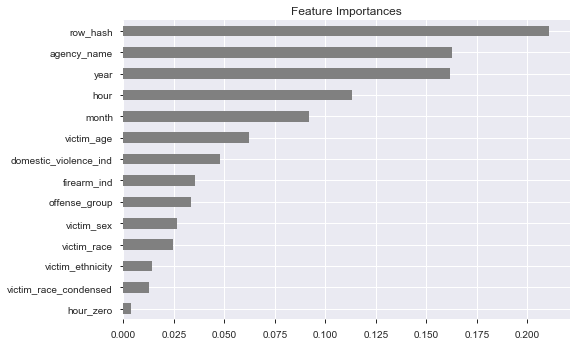

In [12]:
# get feature importances from named steps
pipeline = make_pipeline(
    ce.OrdinalEncoder(),
    SimpleImputer(strategy = "mean"),
    RandomForestClassifier(max_depth = 25, n_estimators = 800, min_samples_leaf = 4, random_state = 42)
    )

pipeline.fit(X_train, y_train)

rf = pipeline.named_steps['randomforestclassifier']
importances = pd.Series(rf.feature_importances_, X_train.columns)
plt.figure()
plt.title("Feature Importances")
importances.sort_values().plot.barh(color='grey');


Awkwardly, row_hash, which is a unique identifier I didn't drop from the data, comes out as the most important feature. This shows the flexibility of random forests, I suppose, but certainly this is not something that I can expect to generalize. 

The agency, unsurprisingly, shows up as very important. The year shows up as very important as well; secular trends might be involved here.

All of these variables would be nice plotted against my target variable for EDA. Perhaps this could even be functionalized. 